# TPM034A Machine Learning for socio-technical systems 
## `Lab session 03:  Decision trees and Random forests`

**Delft University of Technology**<br>
**Q2 2022**<br>
**Instructor:** Sander van Cranenburgh <br>
**TAs:**  Francisco Garrido Valenzuela & Lucas Spierenburg <br>

### `Instructions`

**Lab sessions aim to:**<br>
* Show and reinforce how models and ideas presented in class are used in practice.<br>
* Help you gather hands-on machine learning skills.<br>

**Lab sessions are:**<br>
* Learning environments where you work with Jupyter notebooks and where you can get support from TAs and fellow students.<br> 
* Not graded and do not have to be submitted. 

### `Workspace set-up`
**Option 1: Google Colab**<br>
Uncomment the following cells code lines if you are running this notebook on Colab

In [1]:
#!git clone https://github.com/TPM34A/Q2_2022
#!pip install -r Q2_2022/requirements_colab.txt
#!mv "/content/Q2_2022/Lab_sessions/lab_session_03/data" /content/data

**Option 2: Local environment**<br>
Uncomment the following cell if you are running this notebook on your local environment. This will install all dependencies on your Python version.

In [2]:
#!pip install -r requirements.txt

### `Application: Predicting primary school outflow` <br>
In this lab session we will use decision trees and random forests to predict the **share of school leavers advised to go to higher education (HAVO, VWO)**. In the last year of primary education, schools give their students an advice on their further education. Data on the school advices are collected by the ministry of education to monitor school outflow. These data are also widely used by parents who use them to help choose the primary school for their offspring. Various websites have recently emerged that make these school data easily accessible, see e.g. the screenshot below taken from [allecijfers.nl](https://allecijfers.nl/basisschool/freinetschool-delft/) showing the stats for de Freinet school in Delft.<br>
<br>
![website_reporting_outflow](website_screenshot.jpg)
<br>
<br>
In this lab session we are going to analyse these data. In particular, our **aim** is to answer the following 2 Research Questions (RQs) that parents may consider upon choosing a school for their offspring:
* RQ1: Is the share of school leavers with an advice for higher education, larger at **large schools** than at **small schools**, or vice versa?
* RQ2: Does the type of school (i.e its **denomination**) matters for the share of school leavers with an advice for higher education?<br> 

**Background information on the Dutch school system**<br>
The majority of the schools in the Netherlands are grounded in specific religious or philosophical beliefs, such as Christianity, Protestantism and Anthroposophy. This is called school denomination. Schools that are not grounded in such belief are called "Openbare scholen", meaning "Public schools". Importantly, virtually all schools in the Netherlands are funded by the federal government. Thus, unlike their counterparts in various Anglo-Saxon countries, public schools are generally equally well-funded as schools with specific denominations. 
<br>

**Neighboorhood characteristics**<br>
In the literature, there is ample evidence that neighboorhood characteristics correlate with educational achievements [see e.g. Owens 2018](https://journals.sagepub.com/doi/full/10.1177/0038040717741180). Accordingly, these characteristics can be expected to correlate with our target feature: the share of school leavers with an advice for higher education.<br>

The **conceptual model** for this lab session is shown below. Accordingly, to do the proposed analyses we have pulled together data on:
* School characteristics. These data include the size and denomination of schools (`TOTAL_STUDENTS`, `DENOMINATION`) as well as the share of the school leavers with an educational advice of HAVO or Higher (`SHARE_HIGH`)
* Neighbourhood characteristics. Data on the neighbourhoods in which the schools are located (population density, demography, real-estate value...).

![conceptual_model_lab_ session3](Conceptual_model_lab_session3.png)

<br>

**Learning objectives**. After completing the following exercises you will be able to: <br>
1. Apply multiple ML models to the same data set, including `Linear multiple regressions`, `Decision trees` and `Random Forests`
2. Identify the most important features and their impact on the target feature<br>
3. Explore the pros and cons of each model, and how models can complement each other to answer specific research questions <br>


#### `Organisation`
This lab session comprises **`3`** parts:
1. Loading, exploring and cleaning the data
2. Training multiple models: `Linear multiple regressions`, `Decision trees` and `Random Forests`
3. Comparing and reflecting on the model performances and their outcomes

and comprises **`6`** `exercises`.

In [3]:
# Import required Python packages and modules
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from os import getcwd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV,cross_validate
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,VotingRegressor

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer,log_loss
from sklearn import tree
from sklearn.preprocessing import StandardScaler

# Setting
pd.set_option('display.max_columns', None)

#### **1. Loading, exploring and cleaning the data**

In [4]:
# Load the data into a pandas DataFrame
data_folder = Path('data')
df_schools = pd.read_csv(data_folder/'school_data.csv')

In [5]:
df_schools.head()

,SCHOOL_ID,POLL_DATE_PUPILS,POLL_DATE_ADVISORIES,BRIN_NUMBER,ESTABLISHMENT_NUMBER,INSTITUTION_NAME_BRANCH,ZIPCODE_ESTABLISHMENT,LOCALITY_NAME,MUNICIPAL_NUMBER,MUNICIPAL_NAME,PROVINCE,AUTHORIZED_AUTHORITY_NUMBER,SPECIES_PO,DENOMINATION,ADVICE_NOT_POSSIBLE,TOTAL_ADVICE,Buurt2020,Wijk2020,Buurtnaam2020,Wijknaam2020,number_inhabitants_5,BirthTotal_24,BirthRelative_25,MortalityTotal_26,MortalityRelative_27,Population_Density_33,DegreeOfUrbanity_115,Environmental_Address_Density_116,Men_6,Women_7,k_0To15Years_8,k_15To25Years_9,k_25To45Years_10,k_45To65Years_11,k_65YearsOrder_12,Single_13,Married_14,Divorced_15,Widowed_16,WesternTotal_17,Non-WesternTotal_18,Morocco_19,DutchAntillesAndAruba_20,Suriname_21,Turkey_22,OtherNon-Western_23,HouseholdsTotal_28,Single_Households_29,HouseholdsWithoutChildren_30,HouseholdsWithChildren_31,AverageHouseholdSize_32,Housing_Stock_34,AverageWOZValueOfHomes_35,PercentageFamilyHome_36,PercentageFamilyHome_37,PercentageOccupied_38,PercentUnoccupied_39,Homes_for_Sale_40,Rental_HousingTotal_41,InBezitResidential_42,InPossessionOtherLandlords_43,OwnershipUnknown_44,YearOfConstructionBefore2000_45,YearOfConstructionFrom2000_46,EducationLevelLow_64,EducationLevelMedium_65,EducationLevelHigh_66,pctEducationLevelLow,pctEducationLevelHigh,PassengerCarTotal_99,PassengerCarFuelBenzine_100,PassengerCarSOverigeFuel_101,PassengerCarSPerHousehold_102,PassengerCarSBySurface_103,Motorcycles_104,DistanceToHousehold_105,DistanceToGreatSupermarket_106,DistanceToNursery_107,DistanceToSchool_108,SchoolsWithin3Km_109,geometry,ADIVCE_GIVEN,SHARE_HIGH,TOTAL_STUDENTS,TOTAL_POP,%WesternTotal_17,%Non-WesternTotal_18,%Morocco_19,%DutchAntillesAndAruba_20,%Suriname_21,%Turkey_22,%OtherNon-Western_23
0,00AP-0,20201001,20210729,00AP,0,Wereldwijs,2716PH,ZOETERMEER,637,Zoetermeer,Zuid-Holland,41646,Bo,Gereformeerd vrijgemaakt,0,20,6370100.0,63701.0,Meerzicht-West,Meerzicht,15410.0,145.0,10.0,140.0,9.0,6738.0,1.0,2977.0,7420.0,7990.0,2705.0,1765.0,3790.0,3805.0,3350.0,7610.0,5235.0,1820.0,750.0,1820.0,4115.0,350.0,500.0,1030.0,180.0,2050.0,7260.0,2840.0,1830.0,2595.0,2.1,7284.0,194.0,37.0,63.0,98.0,2.0,45.0,55.0,50.0,5.0,0.0,98.0,2.0,3580.0,4970.0,2610.0,0.320789,0.233871,6070.0,5395.0,680.0,0.8,2654.0,410.0,1.0,0.9,0.5,0.6,12.4,"POLYGON ((92150.00039999932 453177.4882999994,...",20,0.650000,103.0,10045.0,0.181185,0.409657,0.034843,0.049776,0.102539,0.017919,0.204082
1,00AR-0,20201001,20210729,00AR,0,"BS ""De Maasparel""",6107AW,STEVENSWEERT,1641,Maasgouw,Limburg,41797,Bo,Rooms-Katholiek,0,23,16410200.0,164102.0,Stevensweert waaronder Bilt,Wijk 02 Stevensweert,1650.0,10.0,8.0,15.0,9.0,335.0,5.0,234.0,835.0,815.0,215.0,145.0,350.0,520.0,410.0,640.0,785.0,130.0,95.0,210.0,20.0,5.0,5.0,0.0,0.0,15.0,745.0,210.0,305.0,235.0,2.2,722.0,244.0,95.0,5.0,96.0,4.0,82.0,17.0,7.0,10.0,1.0,96.0,4.0,390.0,520.0,370.0,0.304688,0.289062,1045.0,880.0,165.0,1.4,213.0,105.0,0.6,4.8,0.5,0.5,1.0,POLYGON ((187023.40619999915 349535.5938000008...,23,0.304348,150.0,255.0,0.823529,0.078431,0.019608,0.019608,0.000000,0.000000,0.058824
2,00AV-0,20201001,20210729,00AV,0,De Morgenster,3201CN,SPIJKENISSE,1930,Nissewaard,Zuid-Holland,41646,Bo,Gereformeerd vrijgemaakt,0,9,19300103.0,193001.0,Oranjebuurt,Centrum,5810.0,50.0,9.0,80.0,14.0,5935.0,1.0,2892.0,2705.0,3110.0,710.0,545.0,1620.0,1490.0,1460.0,2750.0,1810.0,735.0,505.0,590.0,980.0,50.0,185.0,235.0,140.0,375.0,3100.0,1570.0,775.0,750.0,1.8,3148.0,169.0,34.0,66.0,97.0,3.0,37.0,63.0,55.0,8.0,0.0,78.0,22.0,1660.0,1990.0,750.0,0.377273,0.170455,2490.0,2215.0,275.0,0.8,2545.0,185.0,0.6,0.6,1.3,0.8,15.0,"POLYGON ((81873.86800000072 429841.6068000011,...",9,0.333333,73.0,2555.0,0.230920,0.383562,0.019569,0.072407,0.091977,0.054795,0.146771
3,00AZ-0,20201001,20210729,00AZ,0,De Stapsteen,2971AR,BLESKENSGRAAF CA,1978,Molenlanden,Zuid-Holland,41638,Bo,Openbaar,0,16,19780203.0,197802.0,Bleskensgraaf-Dorp,Wijk02-Bleskensgraaf ca,2870.0,20.0,8.0,30.0,12.0,235.0,5.0,287.0,1445.0,1425.0,625.0,425.0,595.0,690.0,540.0,1315.0,1265.0

Before creating prediction models, we have to understand what features are in your data.<br><br>
Let's start with inspecting the **target feature** `SHARE_HIGH`<br>
`SHARE_HIGH` is the share of the students that have received the advice for further education of HAVO, or higher.

<AxesSubplot:>

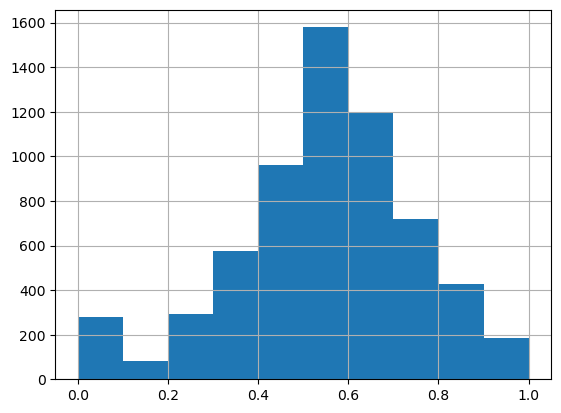

In [6]:
df_schools['SHARE_HIGH'].hist()

From this histogram two observations can be made:
1. The target feature `SHARE_HIGH` is by and large normally distributed.
2. What catches the eye though, is the uptick around zero. 

Next, let's inspect the first (explanatory) feature of interest, i.e. `TOTAL_STUDENTS`.

<AxesSubplot:>

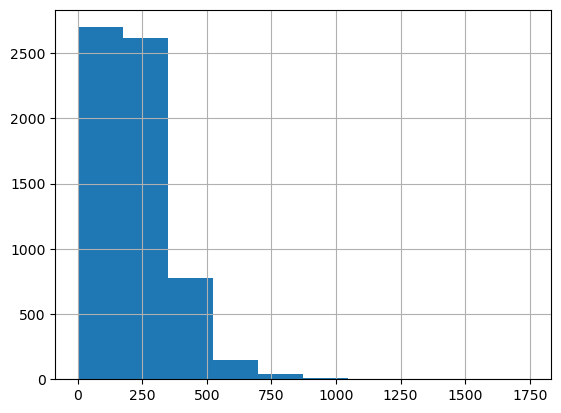

In [7]:
df_schools['TOTAL_STUDENTS'].hist()

In [8]:
# Some buurt features depend on their size (e.g. the number of people under 15 years old for instance).
# We divide these feature by the total number of inhabitants in the neighbourhood (buurt): thus, `number_inhabitants_5`.

# Features to divide by the buurt population.
f2divide = ['Men_6', 'Women_7', 'k_0To15Years_8', 'k_15To25Years_9',
            'k_25To45Years_10', 'k_45To65Years_11', 'k_65YearsOrder_12',
            'Single_13', 'Married_14', 'Divorced_15', 'Widowed_16',
            'WesternTotal_17', 'Non-WesternTotal_18', 'Morocco_19',
            'DutchAntillesAndAruba_20', 'Suriname_21', 'Turkey_22',
            'OtherNon-Western_23', 'HouseholdsTotal_28', 'Single_Households_29',
            'HouseholdsWithoutChildren_30', 'HouseholdsWithChildren_31',
            'Housing_Stock_34','Motorcycles_104','PassengerCarTotal_99']

df_schools.loc[:,f2divide] = df_schools.loc[:,f2divide].div(df_schools['number_inhabitants_5'], axis = 0)

# Some other features are present both in absolute and relative terms. 
# In that case, we keep only the relative terms.
f2remove = ['BirthTotal_24','MortalityTotal_26','EducationLevelLow_64', 'EducationLevelMedium_65',
       'EducationLevelHigh_66','PassengerCarFuelBenzine_100', 'PassengerCarSOverigeFuel_101']

df_schools = df_schools.drop(columns = f2remove)



#### <span style="color:skyblue">Exercise 1: Do school with more than the average number of students have on average higher advices?</span> 
To get a first hunch regarding the first research question:<br>
`A` Create a new column called `SIZE` in the dataframe, consisting of two groups (0,1):<br> 
    0 --> `TOTAL_STUDENTS` smaller than the mean number of students<br>
    1 --> `TOTAL_STUDENTS` larger than the mean number of students<br>
`B` Put the results in a boxplot, where *y* is the target feature (SHARE_HIGH). <br>
`C` What is your first hunch: do large schools perform 'better'? <br>
`D` Suppose that large schools do perform better, what could be a driving force the difference that we observe? <br>

In [9]:
# CODE YOUR ANSWERS HERE (Use as many cells as you need)
# ANSWERS

mean_tot_students = df_schools['TOTAL_STUDENTS'].mean()
df_schools = df_schools.assign(SIZE = lambda x: (x['TOTAL_STUDENTS'] > mean_tot_students).astype(int))
df_schools.head()


,SCHOOL_ID,POLL_DATE_PUPILS,POLL_DATE_ADVISORIES,BRIN_NUMBER,ESTABLISHMENT_NUMBER,INSTITUTION_NAME_BRANCH,ZIPCODE_ESTABLISHMENT,LOCALITY_NAME,MUNICIPAL_NUMBER,MUNICIPAL_NAME,PROVINCE,AUTHORIZED_AUTHORITY_NUMBER,SPECIES_PO,DENOMINATION,ADVICE_NOT_POSSIBLE,TOTAL_ADVICE,Buurt2020,Wijk2020,Buurtnaam2020,Wijknaam2020,number_inhabitants_5,BirthRelative_25,MortalityRelative_27,Population_Density_33,DegreeOfUrbanity_115,Environmental_Address_Density_116,Men_6,Women_7,k_0To15Years_8,k_15To25Years_9,k_25To45Years_10,k_45To65Years_11,k_65YearsOrder_12,Single_13,Married_14,Divorced_15,Widowed_16,WesternTotal_17,Non-WesternTotal_18,Morocco_19,DutchAntillesAndAruba_20,Suriname_21,Turkey_22,OtherNon-Western_23,HouseholdsTotal_28,Single_Households_29,HouseholdsWithoutChildren_30,HouseholdsWithChildren_31,AverageHouseholdSize_32,Housing_Stock_34,AverageWOZValueOfHomes_35,PercentageFamilyHome_36,PercentageFamilyHome_37,PercentageOccupied_38,PercentUnoccupied_39,Homes_for_Sale_40,Rental_HousingTotal_41,InBezitResidential_42,InPossessionOtherLandlords_43,OwnershipUnknown_44,YearOfConstructionBefore2000_45,YearOfConstructionFrom2000_46,pctEducationLevelLow,pctEducationLevelHigh,PassengerCarTotal_99,PassengerCarSPerHousehold_102,PassengerCarSBySurface_103,Motorcycles_104,DistanceToHousehold_105,DistanceToGreatSupermarket_106,DistanceToNursery_107,DistanceToSchool_108,SchoolsWithin3Km_109,geometry,ADIVCE_GIVEN,SHARE_HIGH,TOTAL_STUDENTS,TOTAL_POP,%WesternTotal_17,%Non-WesternTotal_18,%Morocco_19,%DutchAntillesAndAruba_20,%Suriname_21,%Turkey_22,%OtherNon-Western_23,SIZE
0,00AP-0,20201001,20210729,00AP,0,Wereldwijs,2716PH,ZOETERMEER,637,Zoetermeer,Zuid-Holland,41646,Bo,Gereformeerd vrijgemaakt,0,20,6370100.0,63701.0,Meerzicht-West,Meerzicht,15410.0,10.0,9.0,6738.0,1.0,2977.0,0.481506,0.518494,0.175535,0.114536,0.245944,0.246918,0.217391,0.493835,0.339714,0.118105,0.048670,0.118105,0.267034,0.022713,0.032446,0.066840,0.011681,0.133030,0.471123,0.184296,0.118754,0.168397,2.1,0.472680,194.0,37.0,63.0,98.0,2.0,45.0,55.0,50.0,5.0,0.0,98.0,2.0,0.320789,0.233871,0.393900,0.8,2654.0,0.026606,1.0,0.9,0.5,0.6,12.4,"POLYGON ((92150.00039999932 453177.4882999994,...",20,0.650000,103.0,10045.0,0.181185,0.409657,0.034843,0.049776,0.102539,0.017919,0.204082,0
1,00AR-0,20201001,20210729,00AR,0,"BS ""De Maasparel""",6107AW,STEVENSWEERT,1641,Maasgouw,Limburg,41797,Bo,Rooms-Katholiek,0,23,16410200.0,164102.0,Stevensweert waaronder Bilt,Wijk 02 Stevensweert,1650.0,8.0,9.0,335.0,5.0,234.0,0.506061,0.493939,0.130303,0.087879,0.212121,0.315152,0.248485,0.387879,0.475758,0.078788,0.057576,0.127273,0.012121,0.003030,0.003030,0.000000,0.000000,0.009091,0.451515,0.127273,0.184848,0.142424,2.2,0.437576,244.0,95.0,5.0,96.0,4.0,82.0,17.0,7.0,10.0,1.0,96.0,4.0,0.304688,0.289062,0.633333,1.4,213.0,0.063636,0.6,4.8,0.5,0.5,1.0,POLYGON ((187023.40619999915 349535.5938000008...,23,0.304348,150.0,255.0,0.823529,0.078431,0.019608,0.019608,0.000000,0.000000,0.058824,0
2,00AV-0,20201001,20210729,00AV,0,De Morgenster,3201CN,SPIJKENISSE,1930,Nissewaard,Zuid-Holland,41646,Bo,Gereformeerd vrijgemaakt,0,9,19300103.0,193001.0,Oranjebuurt,Centrum,5810.0,9.0,14.0,5935.0,1.0,2892.0,0.465577,0.535284,0.122203,0.093804,0.278830,0.256454,0.251291,0.473322,0.311532,0.126506,0.086919,0.101549,0.168675,0.008606,0.031842,0.040448,0.024096,0.064544,0.533563,0.270224,0.133391,0.129088,1.8,0.541824,169.0,34.0,66.0,97.0,3.0,37.0,63.0,55.0,8.0,0.0,78.0,22.0,0.377273,0.170455,0.428571,0.8,2545.0,0.031842,0.6,0.6,1.3,0.8,15.0,"POLYGON ((81873.86800000072 429841.6068000011,...",9,0.333333,73.0,2555.0,0.230920,0.383562,0.019569,0.072407,0.091977,0.054795,0.146771,0
3,00AZ-0,20201001,20210729,00AZ,0,De Stapsteen,2971AR,BLESKENSGRAAF CA,1978,Molenlanden,Zuid-Holland,41638,Bo,Openbaar,0,16,19780203.0,197802.0,Bleskensgraaf-Dorp,Wijk02-Bleskensgraaf ca,2870.0,8.0,12.0,235.0,5.0,287.0,0.503484,0.496516,0.217770,0.148084,0.207317,0.240418,0.188153,0.458188,0.440767,0.036585,0.060976,0.034843,0.034843,0.000000,0.003484,0

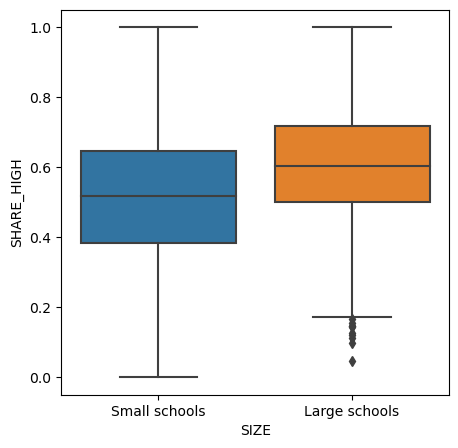

In [10]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5), sharex=True)
sns.boxplot(y= df_schools['SHARE_HIGH'],x= df_schools['SIZE'], data=df_schools)

#
axes.set_xticklabels(['Small schools','Large schools'])

plt.show()

Large schools seem to perform slightly better, but this doesn't seem significant.\
A driving force could be that large schools are often more in the centre, where richer/higher educated people live. Higher educated parents can be a factor in the childs intelligence. 

Next, we inspect the second feature of interest, i.e. the `DENOMINATION`.


<AxesSubplot:>

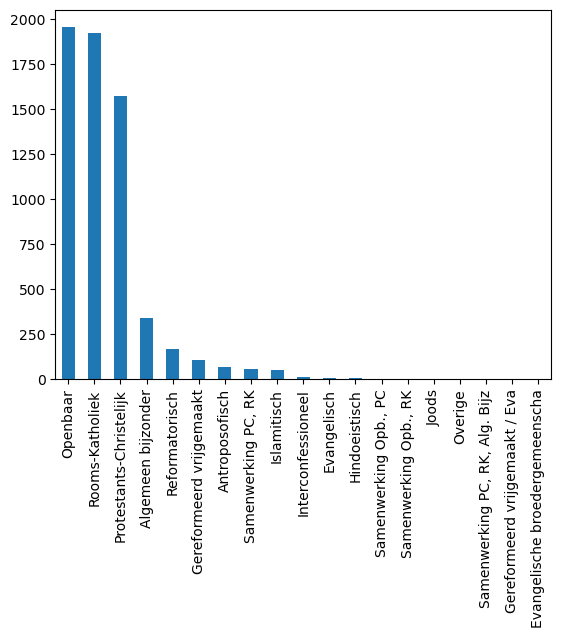

In [11]:
df_schools['DENOMINATION'].value_counts().plot(kind='bar')

As we can see in the histogram, the distribution of "DENOMINATION" is highly skewed. Therefore, for our later analyses, we merge the little occuring categories into one new category called "DENOMINATION_Other"

In [12]:
# Replace little occuring denomination with the category 'Other

# Create a list with little occuring denominations 
df_schools_denom_count = df_schools['DENOMINATION'].value_counts()

# Identify the denominations to be pulled together
denomination_threshold = 100
denom2merge= list(df_schools_denom_count.index[df_schools_denom_count<denomination_threshold])

# Replace little occuring denomitations with Other
df_schools['DENOMINATION'].replace(denom2merge,'Other',inplace = True)

# Show the new categories and their counts
df_schools['DENOMINATION'].value_counts()

Openbaar                    1954
Rooms-Katholiek             1922
Protestants-Christelijk     1574
Algemeen bijzonder           342
Other                        226
Reformatorisch               168
Gereformeerd vrijgemaakt     107
Name: DENOMINATION, dtype: int64

Let's investigate the spread and skewness of "SHARE_HIGH" across school with different "DENOMINATION_ESTABLISHMENT". Hence, we create a boxplot.

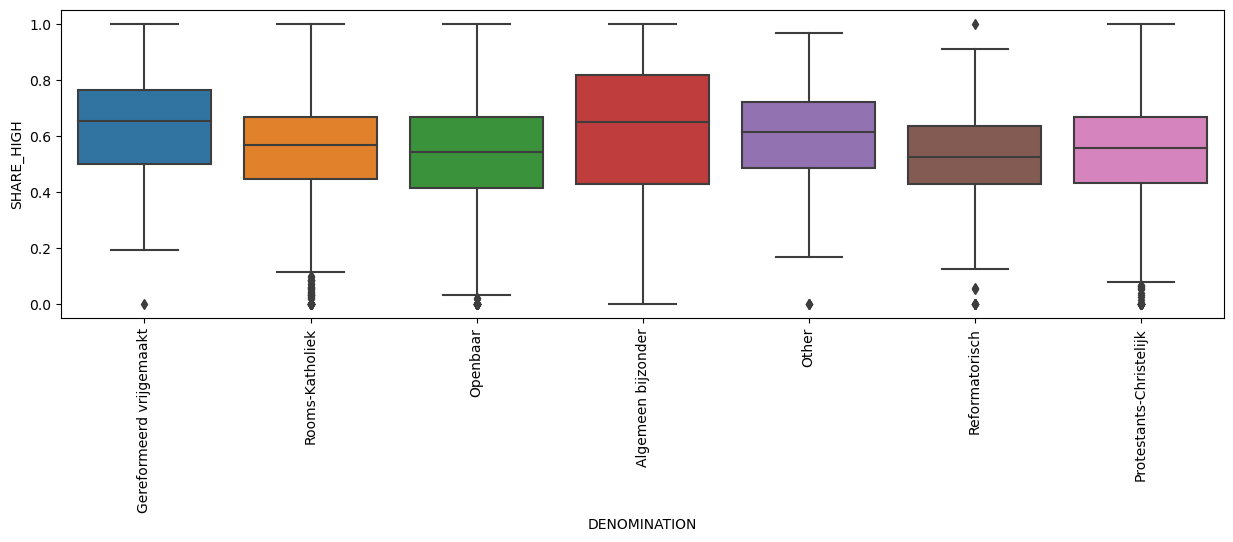

In [13]:
fig, ax = plt.subplots(1,1,figsize =(15,4))
sns.boxplot(x='DENOMINATION', y='SHARE_HIGH', data=df_schools, ax= ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

The boxplot shows no particular trend betweem denomination and school performance (i.e. SHARE_HIGH) 

All the features that we want to us in our ML models must be either *floats* or *integers*. Hence, we must convert categorial features (strings) of interest into dummy coded features. The only categorical feature of interest is `DENOMINATION`. Other categorical features, such as `INSTITUTION_NAME_BRANCH`, `LOCALITY_NAME`, `PROVINCE`, and  `SPECIES_PO` do not seem to be of interest and not converted into dummies.

In [14]:
cat_features = ['DENOMINATION']
df_schools_cat = pd.get_dummies(df_schools[cat_features], columns = cat_features)

# Concatenate the categorical data and the original df
df_schools = pd.concat([df_schools,df_schools_cat], axis =1)

# Show the first line of the data frame
df_schools.head(1)

,SCHOOL_ID,POLL_DATE_PUPILS,POLL_DATE_ADVISORIES,BRIN_NUMBER,ESTABLISHMENT_NUMBER,INSTITUTION_NAME_BRANCH,ZIPCODE_ESTABLISHMENT,LOCALITY_NAME,MUNICIPAL_NUMBER,MUNICIPAL_NAME,PROVINCE,AUTHORIZED_AUTHORITY_NUMBER,SPECIES_PO,DENOMINATION,ADVICE_NOT_POSSIBLE,TOTAL_ADVICE,Buurt2020,Wijk2020,Buurtnaam2020,Wijknaam2020,number_inhabitants_5,BirthRelative_25,MortalityRelative_27,Population_Density_33,DegreeOfUrbanity_115,Environmental_Address_Density_116,Men_6,Women_7,k_0To15Years_8,k_15To25Years_9,k_25To45Years_10,k_45To65Years_11,k_65YearsOrder_12,Single_13,Married_14,Divorced_15,Widowed_16,WesternTotal_17,Non-WesternTotal_18,Morocco_19,DutchAntillesAndAruba_20,Suriname_21,Turkey_22,OtherNon-Western_23,HouseholdsTotal_28,Single_Households_29,HouseholdsWithoutChildren_30,HouseholdsWithChildren_31,AverageHouseholdSize_32,Housing_Stock_34,AverageWOZValueOfHomes_35,PercentageFamilyHome_36,PercentageFamilyHome_37,PercentageOccupied_38,PercentUnoccupied_39,Homes_for_Sale_40,Rental_HousingTotal_41,InBezitResidential_42,InPossessionOtherLandlords_43,OwnershipUnknown_44,YearOfConstructionBefore2000_45,YearOfConstructionFrom2000_46,pctEducationLevelLow,pctEducationLevelHigh,PassengerCarTotal_99,PassengerCarSPerHousehold_102,PassengerCarSBySurface_103,Motorcycles_104,DistanceToHousehold_105,DistanceToGreatSupermarket_106,DistanceToNursery_107,DistanceToSchool_108,SchoolsWithin3Km_109,geometry,ADIVCE_GIVEN,SHARE_HIGH,TOTAL_STUDENTS,TOTAL_POP,%WesternTotal_17,%Non-WesternTotal_18,%Morocco_19,%DutchAntillesAndAruba_20,%Suriname_21,%Turkey_22,%OtherNon-Western_23,SIZE,DENOMINATION_Algemeen bijzonder,DENOMINATION_Gereformeerd vrijgemaakt,DENOMINATION_Openbaar,DENOMINATION_Other,DENOMINATION_Protestants-Christelijk,DENOMINATION_Reformatorisch,DENOMINATION_Rooms-Katholiek
0,00AP-0,20201001,20210729,00AP,0,Wereldwijs,2716PH,ZOETERMEER,637,Zoetermeer,Zuid-Holland,41646,Bo,Gereformeerd vrijgemaakt,0,20,6370100.0,63701.0,Meerzicht-West,Meerzicht,15410.0,10.0,9.0,6738.0,1.0,2977.0,0.481506,0.518494,0.175535,0.114536,0.245944,0.246918,0.217391,0.493835,0.339714,0.118105,0.04867,0.118105,0.267034,0.022713,0.032446,0.06684,0.011681,0.13303,0.471123,0.184296,0.118754,0.168397,2.1,0.47268,194.0,37.0,63.0,98.0,2.0,45.0,55.0,50.0,5.0,0.0,98.0,2.0,0.320789,0.233871,0.3939,0.8,2654.0,0.026606,1.0,0.9,0.5,0.6,12.4,"POLYGON ((92150.00039999932 453177.4882999994,...",20,0.65,103.0,10045.0,0.181185,0.409657,0.034843,0.049776,0.102539,0.017919,0.204082,0,0,1,0,0,0,0,0


To identify other urban or school related features that could help predict the target (SHARE_HIGH), we create a heatmap showing the correlations across the features.

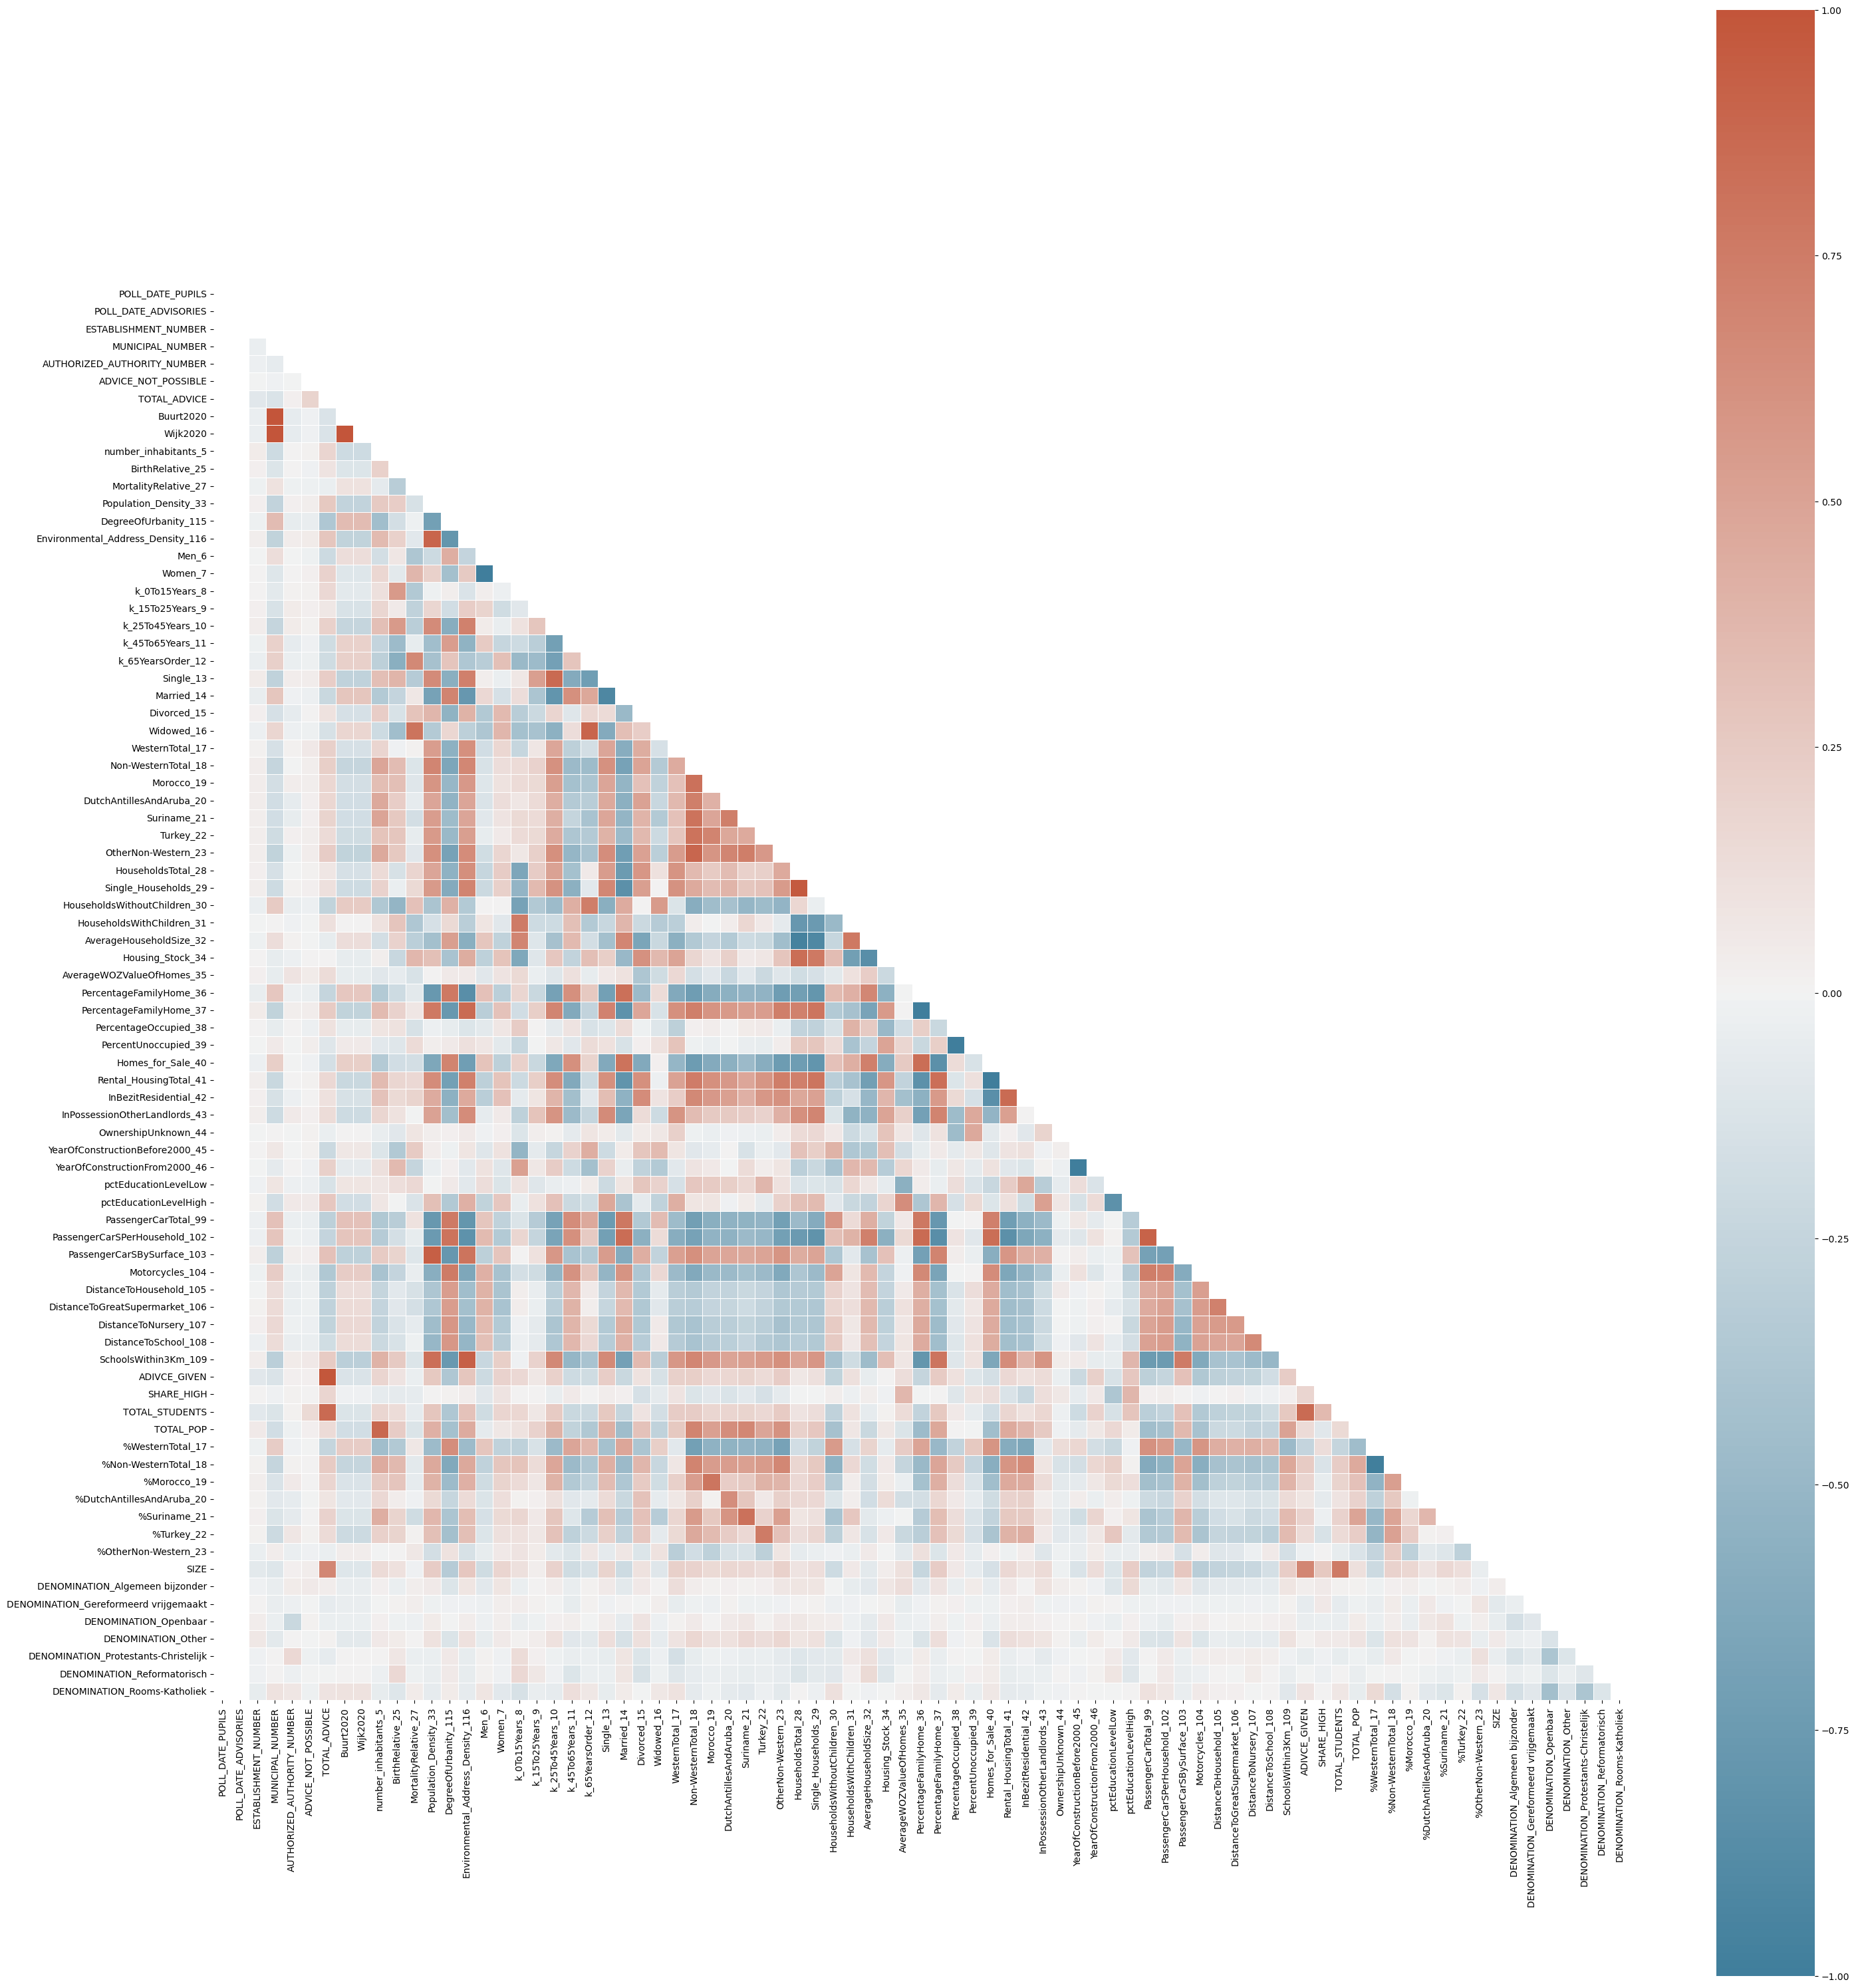

In [15]:
# heatmap of correlations
# Create plot
fig, axes = plt.subplots(figsize=(30, 30))
fig.set_tight_layout(True)

# Compute correlation matrix
corr = df_schools.corr()

# Create upper triangular matrix to mask the upper triangular part of the heatmap
corr_mask = np.triu(np.ones_like(corr, dtype=bool))

# Generate a custom diverging colormap (because it looks better)
corr_cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask = corr_mask, cmap=corr_cmap, annot=False,square = True, linewidths=.5, ax = axes)
plt.show()

We are specifically interested in the features that correlate with `HIGH_SHARE`. If a feature does not correlate with the target, it is unlikely it will help the model predict the target. Therefore, we create a list with 30 features that correlate strongest with the target feature. These features will be used in to train the ML models.

In [16]:
# Compute absolute correlations with the target 
df_corr = corr[['SHARE_HIGH']].abs().sort_values(by=['SHARE_HIGH'],ascending=False).T

# Sort the features based the the strength of the correlation
features_corr_sorted  = list(df_corr.keys())

# Create list with the 30 most strongly correlated features, (we start at the index 1 to exclude the target itself)
features_corr = features_corr_sorted[1:31]
print(f'Features with the strongest correlation with the target:\n {features_corr}')

Features with the strongest correlation with the target:
 ['pctEducationLevelHigh', 'pctEducationLevelLow', 'AverageWOZValueOfHomes_35', 'TOTAL_STUDENTS', 'SIZE', 'InBezitResidential_42', 'ADIVCE_GIVEN', 'TOTAL_ADVICE', 'Turkey_22', 'Divorced_15', '%Turkey_22', '%Non-WesternTotal_18', '%WesternTotal_17', 'DutchAntillesAndAruba_20', 'Rental_HousingTotal_41', 'Homes_for_Sale_40', 'InPossessionOtherLandlords_43', 'Non-WesternTotal_18', 'PercentageOccupied_38', 'PercentUnoccupied_39', 'WesternTotal_17', 'TOTAL_POP', 'Morocco_19', 'Women_7', 'Men_6', 'Suriname_21', 'BirthRelative_25', 'Widowed_16', '%DutchAntillesAndAruba_20', 'OtherNon-Western_23']


Regardless of whether e.g. `DENOMINATION` and `TOTAL_STUDENTS` correlate with the target, we must include them in our list of features. TOTAL_STUDENTS is already in the list of features that strongly correlate with the target. So, we only have to add the list of features of the denominations.

In [17]:
features = features_corr + list(df_schools_cat.keys())
print(f'Total list of features:\n {features}')

Total list of features:
 ['pctEducationLevelHigh', 'pctEducationLevelLow', 'AverageWOZValueOfHomes_35', 'TOTAL_STUDENTS', 'SIZE', 'InBezitResidential_42', 'ADIVCE_GIVEN', 'TOTAL_ADVICE', 'Turkey_22', 'Divorced_15', '%Turkey_22', '%Non-WesternTotal_18', '%WesternTotal_17', 'DutchAntillesAndAruba_20', 'Rental_HousingTotal_41', 'Homes_for_Sale_40', 'InPossessionOtherLandlords_43', 'Non-WesternTotal_18', 'PercentageOccupied_38', 'PercentUnoccupied_39', 'WesternTotal_17', 'TOTAL_POP', 'Morocco_19', 'Women_7', 'Men_6', 'Suriname_21', 'BirthRelative_25', 'Widowed_16', '%DutchAntillesAndAruba_20', 'OtherNon-Western_23', 'DENOMINATION_Algemeen bijzonder', 'DENOMINATION_Gereformeerd vrijgemaakt', 'DENOMINATION_Openbaar', 'DENOMINATION_Other', 'DENOMINATION_Protestants-Christelijk', 'DENOMINATION_Reformatorisch', 'DENOMINATION_Rooms-Katholiek']


Let's check the ranges of our features. This is relevant to know when interpreting the results of the regression model.

In [18]:
df_schools[features].describe()

,pctEducationLevelHigh,pctEducationLevelLow,AverageWOZValueOfHomes_35,TOTAL_STUDENTS,SIZE,InBezitResidential_42,ADIVCE_GIVEN,TOTAL_ADVICE,Turkey_22,Divorced_15,%Turkey_22,%Non-WesternTotal_18,%WesternTotal_17,DutchAntillesAndAruba_20,Rental_HousingTotal_41,Homes_for_Sale_40,InPossessionOtherLandlords_43,Non-WesternTotal_18,PercentageOccupied_38,PercentUnoccupied_39,WesternTotal_17,TOTAL_POP,Morocco_19,Women_7,Men_6,Suriname_21,BirthRelative_25,Widowed_16,%DutchAntillesAndAruba_20,OtherNon-Western_23,DENOMINATION_Algemeen bijzonder,DENOMINATION_Gereformeerd vrijgemaakt,DENOMINATION_Openbaar,DENOMINATION_Other,DENOMINATION_Protestants-Christelijk,DENOMINATION_Reformatorisch,DENOMINATION_Rooms-Katholiek
count,6293.000000,6293.000000,6293.000000,6293.000000,6293.000000,6293.000000,6293.000000,6293.000000,6293.000000,6293.000000,6293.000000,6293.000000,6293.000000,6293.000000,6293.000000,6293.000000,6293.000000,6293.000000,6293.000000,6293.000000,6293.000000,6293.000000,6293.000000,6293.000000,6293.000000,6293.000000,6293.000000,6293.000000,6293.000000,6293.000000,6293.000000,6293.000000,6293.000000,6293.000000,6293.000000,6293.000000,6293.000000
mean,0.288633,0.282286,271.351184,216.772604,0.424122,26.894486,28.796917,28.980931,0.020346,0.075493,0.044024,0.311774,0.377739,0.007987,37.836008,61.809471,10.948514,0.116548,95.933418,4.066582,0.093522,6594.508978,0.019139,0.502476,0.497450,0.016849,9.593199,0.050615,0.021507,0.052193,0.054346,0.017003,0.310504,0.035913,0.250119,0.026696,0.305419
std,0.110826,0.067841,94.176273,142.486777,0.494248,13.053036,17.749853,18.079976,0.035490,0.020313,0.047006,0.080901,0.162525,0.010770,15.280159,15.333216,7.910390,0.127513,2.876873,2.876873,0.051544,14230.216503,0.034874,0.013210,0.013254,0.031030,2.718184,0.016841,0.016669,0.042236,0.226717,0.129293,0.462737,0.186088,0.433116,0.161207,0.460621
min,0.054852,0.041667,109.000000,0.000000,0.000000,0.000000,2.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,11.000000,1.000000,0.000000,33.000000,0.000000,0.000000,0.000000,0.000000,0.417623,0.435995,0.000000,0.000000,0.003797,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.215496,0.241935,213.000000,116.000000,0.000000,18.000000,16.000000,16.000000,0.001800,0.061122,0.011429,0.260388,0.255319,0.002010,27.000000,55.000000,6.000000,0.035256,95.000000,3.000000,0.058366,795.000000,0.001336,0.495430,0.489819,0.002668,8.000000,0.039453,0.011259,0.023894,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.264414,0.284926,256.000000,194.000000,0.000000,25.000000,25.000000,25.000000,0.006583,0.074761,0.026316,0.317739,0.364952,0.004436,35.000000,65.000000,9.000000,0.069218,97.000000,3.000000,0.085736,2370.000000,0.005806,0.503240,0.496747,0.005963,9.000000,0.051169,0.018426,0.038333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.333333,0.324916,311.000000,286.000000,1.000000,33.000000,38.000000,38.000000,0.022459,0.089200,0.062500,0.372059,0.478261,0.009007,45.000000,72.000000,12.000000,0.146649,97.000000,5.000000,0.115646,5810.000000,0.020882,0.510112,0.504433,0.016086,11.000000,0.061440,0.027690,0.068002,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,0.723404,0.594937,1166.000000,1746.000000,1.000000,82.000000,173.000000,271.000000,0.377715,0.157171,0.297297,0.500000,1.000000,0.095885,89.000000,99.000000,84.000000,0.826142,100.000000,67.000000,0.614525,96380.000000,0.276575,0.562738,0.600000,0.314931,35.000000,0.156823,0.333333,0.325847,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Now we can create the train and test data sets, which we will use to train our ML models.

In [19]:
# Create train and test data 

# Create a df with the features only 
X = df_schools[features]

# Target
Y = df_schools.loc[:,'SHARE_HIGH']

# Split the data into a train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,random_state=12)

#### **2. Training multiple models: Regression model, Decision tree, and a Random forest**<br>
Often, a researcher does not know beforehand which sort of model will do well, and which will not. Therefore, ML researchers often apply multiple models to their task and pull together their outcomes.<br>
Next, we are going to apply 3 models:
1. Regression model (benchmark model)<br>
2. Decision tree<br>
3. Random Forest<br>

As we will see, each of these models provide complementary insights.

Because we are going to compare different models, we create a custom evaluation function that allows us to swiftly report the following stats for the train and test data:
* mean square error
* mean absolute error
* R2

In [20]:
def eval_regression_perf(model, X_train, X_test, Y_train, Y_test):
    
    # Make prediction with the trained model
    Y_pred_train = model.predict(X_train)
    Y_pred_test = model.predict(X_test)

    # Create a function that computes the MSE, MAE, and R2
    def perfs(Y,Y_pred):
        mse = mean_squared_error(Y,Y_pred)
        mae = mean_absolute_error(Y,Y_pred)
        R2 = r2_score(Y,Y_pred)
        return mse,mae,R2

    # Apply the perfs function to the train and test data sets
    mse_train, mae_train, r2_train = perfs(Y_train,Y_pred_train)
    mse_test,  mae_test , r2_test  = perfs(Y_test,Y_pred_test)
        
    # Print results
    print('Performance')
    print(f'Mean Squared  Error Train | Test: \t{mse_train:>7.4f}\t|  {mse_test:>7.4f}')
    print(f'Mean Absolute Error Train | Test: \t{mae_train:>7.4f}\t|  {mae_test:>7.4f}')
    print(f'R2                  Train | Test: \t{ r2_train:>7.4f}\t|  {r2_test:>7.4f}\n')

##### 2.1. Linear multiple regression model
This model usually serves as a benchmark when creating ML models. Therefore, we start with this model.

In [21]:
# Create and train a multiple linear regression model
regr = LinearRegression(fit_intercept = True)

# Fit the model on the training data
regr.fit(X_train,Y_train)

# Evaluate the performance of the trained model
eval_regression_perf(regr, X_train, X_test, Y_train, Y_test)

# We take an ML approach (i.e. we use a train and tests set). But, if we deem the assumptions one would take from a statistical approach plausible, 
# then the weights obtained here are also interpretable. Let's therefore print the weights of the trained model
print('Weights')
print(f'Intercept: \t\t\t\t\t\t {regr.intercept_:>7.4f}')
for n in range(len(regr.coef_)):
    print(f'Weight_{X.keys()[n]:32s} \t\t {regr.coef_[n]:>7.4f}')

Performance
Mean Squared  Error Train | Test: 	 0.0267	|   0.0269
Mean Absolute Error Train | Test: 	 0.1286	|   0.1296
R2                  Train | Test: 	 0.3513	|   0.3674

Weights
Intercept: 						 -3.6188
Weight_pctEducationLevelHigh            		  0.2821
Weight_pctEducationLevelLow             		 -0.2552
Weight_AverageWOZValueOfHomes_35        		  0.0003
Weight_TOTAL_STUDENTS                   		  0.0010
Weight_SIZE                             		  0.0040
Weight_InBezitResidential_42            		 -0.0058
Weight_ADIVCE_GIVEN                     		  0.0017
Weight_TOTAL_ADVICE                     		 -0.0070
Weight_Turkey_22                        		  1.1652
Weight_Divorced_15                      		 -0.0856
Weight_%Turkey_22                       		 -0.1286
Weight_%Non-WesternTotal_18             		  0.4637
Weight_%WesternTotal_17                 		  0.2771
Weight_DutchAntillesAndAruba_20         		  0.1933
Weight_Rental_HousingTotal_41           		 -0.0013
Weight_Homes_for_Sale_40  

Based on these results, we can make several inferences:
1. The model fit is not great but also not very bad (R2 of ~0.35)
2. The model does not seem to overfit the data: it attains the same performance on the test as on the train data sets
3. From the positive weight associated with TOTAL_STUDENTS, we tentatively conclude that larger schools result in on avg higher share of advices for higher education.
4. From the weights associated with school denomination, we tentatively conclude that some denominations might impact on the share of advices for higher education.
5. From the remaining weights, we infer that their signs are mostly in line with intuition.


##### 2.2. Decision tree
The next ML model we will try on these data is the decision tree.

Performance
Mean Squared  Error Train | Test: 	 0.0225	|   0.0226
Mean Absolute Error Train | Test: 	 0.1169	|   0.1171
R2                  Train | Test: 	 0.4528	|   0.4691



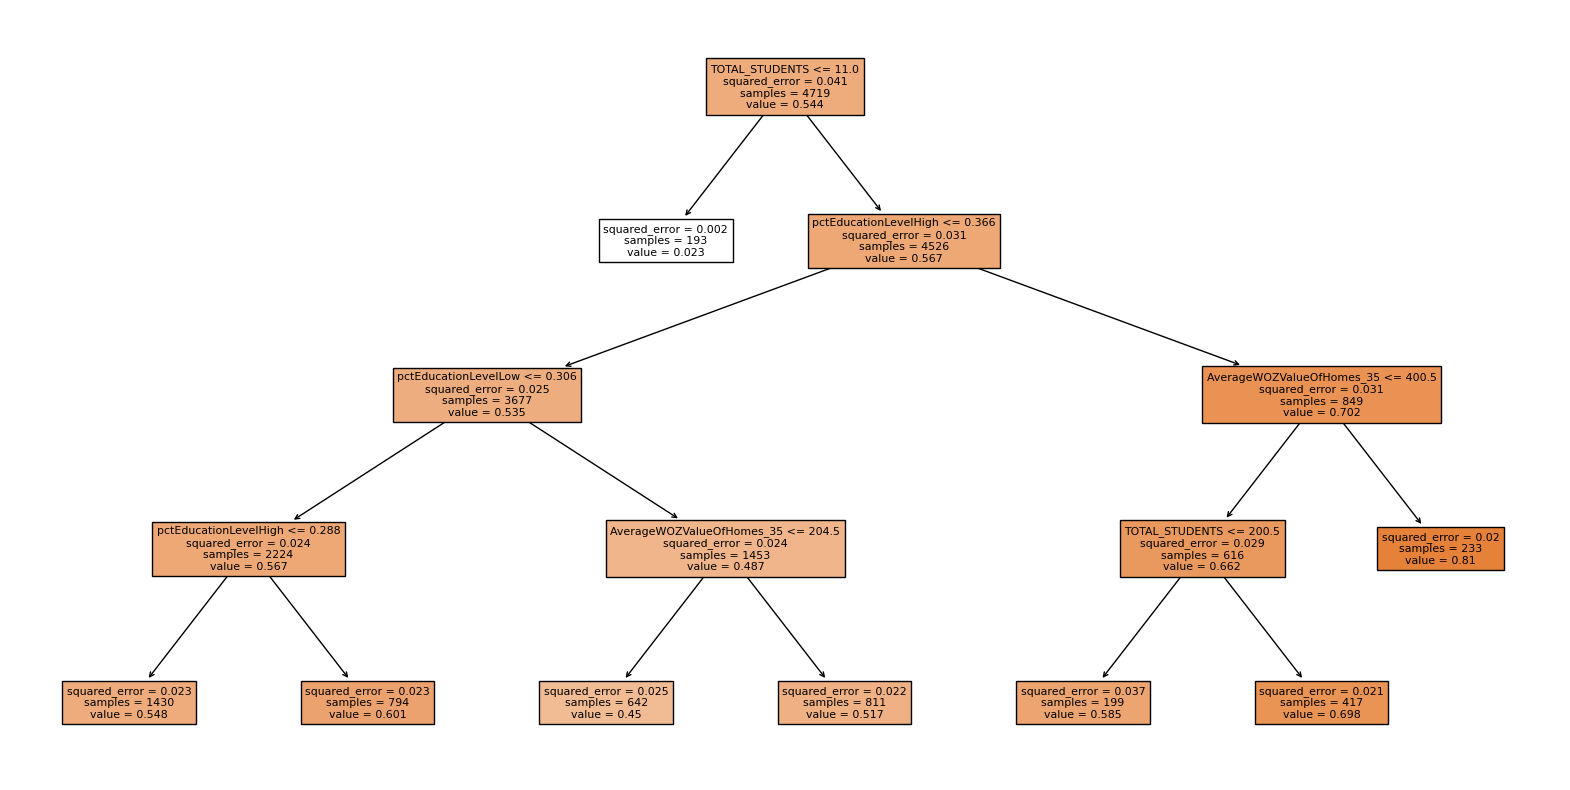

In [22]:
# Create and train a decision tree
max_depth =4
max_leaf_nodes = 8
min_samples_leaf = 100
dt = DecisionTreeRegressor(criterion = "squared_error", max_depth=max_depth, max_leaf_nodes = max_leaf_nodes,min_samples_leaf=min_samples_leaf,random_state=5)

# Train the decision tree
dt.fit(X_train,Y_train)

# Evaluate the performance of the trained model
eval_regression_perf(dt, X_train, X_test, Y_train, Y_test)

# Visualise the decision tree
fig = plt.figure(figsize=(20,10))
tree.plot_tree(dt, feature_names = features, filled=True)
plt.show()

From the decision tree, we can make several observations:
1. Compared to the regression model, the model fit (in terms of e.g. R2) has substantially improved
2. The decison tree does not seem to over fit: the performance of the train and test data are more or less the same.
3. The tree is easily interpretable. Moreover, the tree structure (splits) are in line with intuition.

### <span style="color:skyblue">Exercise 2: Manually navigate through the decision tree to obtain a prediction for the first instance of X_test (X_test.loc[0])</span> 

In [23]:
# CODE YOUR ANSWERS HERE (Use as many cells as you need)
# ANSWERS
X_test.loc[0].TOTAL_STUDENTS # Right 
X_test.loc[0].pctEducationLevelHigh # 0.233870967741935 Left
X_test.loc[0].pctEducationLevelLow # 0.320789 Right 
X_test.loc[0].AverageWOZValueOfHomes_35 # 194.000000 # Left 

# End up in leaf 3 


194.0

Let's see which features are found to be most important to our Decision tree.

Top 5 most important features:
 ['TOTAL_STUDENTS', 'pctEducationLevelHigh', 'pctEducationLevelLow', 'AverageWOZValueOfHomes_35', '%Turkey_22']


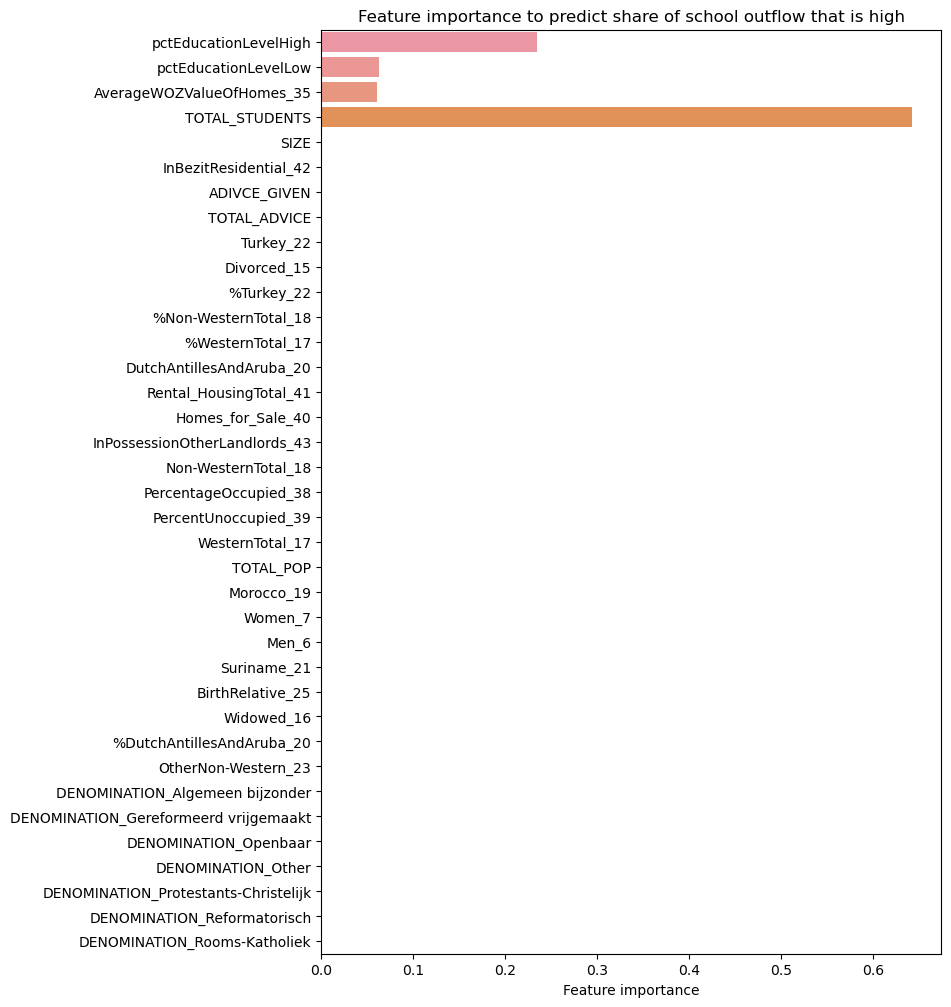

In [24]:
fig, ax = plt.subplots(figsize=(8,12))
sns.barplot(y=features,x=dt.feature_importances_, ax = ax).set(title='Feature importance to predict share of school outflow that is high')
ax.set_xlabel('Feature importance')

# Print most important features
sorted_indices = np.argsort(dt.feature_importances_)[::-1]
most_imp_features_dt = [features[i] for i in sorted_indices]
print(f'Top 5 most important features:\n {most_imp_features_dt[:5]}')

# Show the plot
plt.show()

From the importance plot, we can draw several conclusions:
1. Most features seem not to help predict the target: many features attain a (nearly) zero feature_importances
2. Just four features seem important to predict the target: 'TOTAL_STUDENTS', 'pctEducationLevelHigh', 'pctEducationLevelLow', 'AverageWOZValueOfHomes_35'. These feature are in line with expectations.
3. The school denomination seems unimportant in the predictions

### <span style="color:skyblue">Exercise 3: Try to improve the model fit of the decision tree, by testing different numbers for:</span> 
* max_depth <br>
* max_leaf_nodes<br>
* min_samples_leaf<br>

How does each of these hyperparameters affects:<br>
`A` The size of the tree<br>
`B` Model performance, in terms of R2. <br>
`C` Feature importance <br>

Performance
Mean Squared  Error Train | Test: 	 0.0222	|   0.0225
Mean Absolute Error Train | Test: 	 0.1161	|   0.1170
R2                  Train | Test: 	 0.4592	|   0.4715



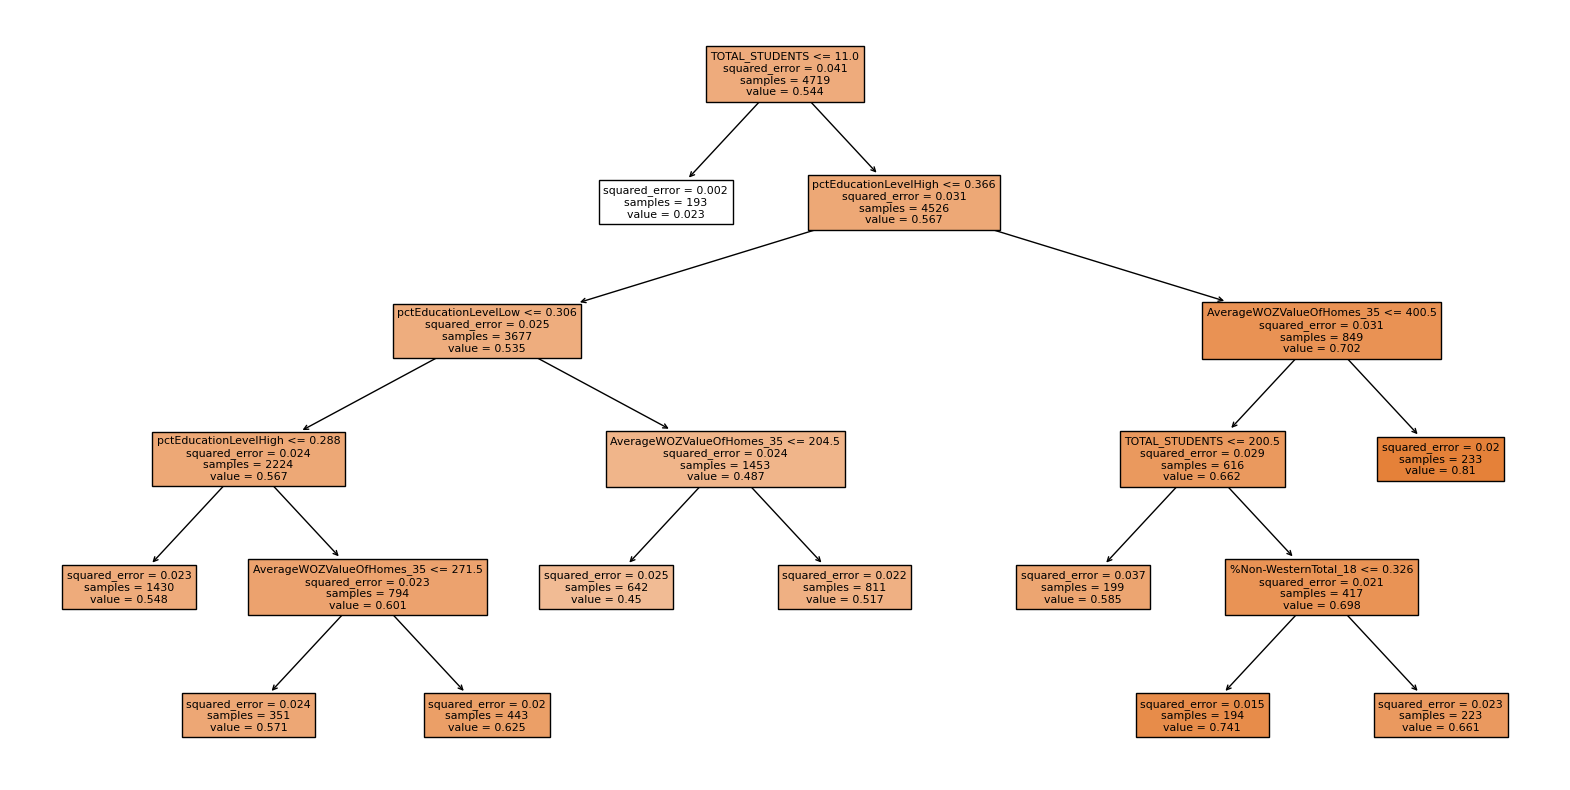

In [25]:
# CODE YOUR ANSWERS HERE (Use as many cells as you need)
# ANSWERS

# Create and train a decision tree
max_depth =5
max_leaf_nodes = 10
min_samples_leaf = 100
dt = DecisionTreeRegressor(criterion = "squared_error", max_depth=max_depth, max_leaf_nodes = max_leaf_nodes,min_samples_leaf=min_samples_leaf,random_state=5)

# Train the decision tree
dt.fit(X_train,Y_train)

# Evaluate the performance of the trained model
eval_regression_perf(dt, X_train, X_test, Y_train, Y_test)

# Visualise the decision tree
fig = plt.figure(figsize=(20,10))
tree.plot_tree(dt, feature_names = features, filled=True)
plt.show()

##### 2.3. Random Forest
Lastly, we are going to try a RF on these data. RFs are known to attain a high model performance on a wide range of regression and classification tasks. 
<br>
Instead of manually searching for the optimal hyperparameters for the RF, which is laborious, let's use sk-learn's GridSearchCV functionality to automate the hyperparameter search.

In [26]:
# Create RF object
rf_gs = RandomForestRegressor(n_estimators=250,criterion= "squared_error",random_state=5)

# Define the hyperparameter search space
hyperparameter_space = {
    'max_depth': [5,7, 9, 11],
    'max_leaf_nodes': [20,30],
    'min_samples_leaf': [50, 100],
    'max_features':[0.5,0.7,0.9]}

# Create scoring function
scorer = make_scorer(mean_squared_error, greater_is_better = False)

# Create the grid_search object, with using the MLP classifier
folds = 5 # Number of cross validation splits
rf_gridsearch = GridSearchCV(rf_gs, hyperparameter_space, n_jobs=-1, cv=folds, scoring=scorer, return_train_score=True)

In [27]:
# Execute the training/gridsearch
# Note that this is computationally expensive! 
# It may take up to 5 minutes, since multiple models need to be trained multiple times
rf_gridsearch.fit(X_train,Y_train)
print(f'Optimal hyperparameters:\n{rf_gridsearch.best_params_}')
print(f'Mean Squared Error:\t{(-rf_gridsearch.best_score_):0.3f}') 

Optimal hyperparameters:
{'max_depth': 9, 'max_features': 0.9, 'max_leaf_nodes': 30, 'min_samples_leaf': 50}
Mean Squared Error:	0.022


In [28]:
# Set the hyperparameters of the Random Forest to the best values found, e.g. 
max_depth = 9
max_features = 0.9
max_leaf_nodes = 30
min_samples_leaf = 50

# Create the Random Forest object with the best hyperparameters
rf = RandomForestRegressor(criterion = "squared_error", n_estimators=1000, max_features=max_features, max_depth=max_depth, max_leaf_nodes = max_leaf_nodes,min_samples_leaf=min_samples_leaf,random_state=5)

# Train the Randon Forest
rf.fit(X_train,Y_train)

# Evaluate the performance of the hyperparameter optimised RF model
eval_regression_perf(rf,X_train,X_test, Y_train, Y_test)

Performance
Mean Squared  Error Train | Test: 	 0.0196	|   0.0214
Mean Absolute Error Train | Test: 	 0.1088	|   0.1136
R2                  Train | Test: 	 0.5238	|   0.4975



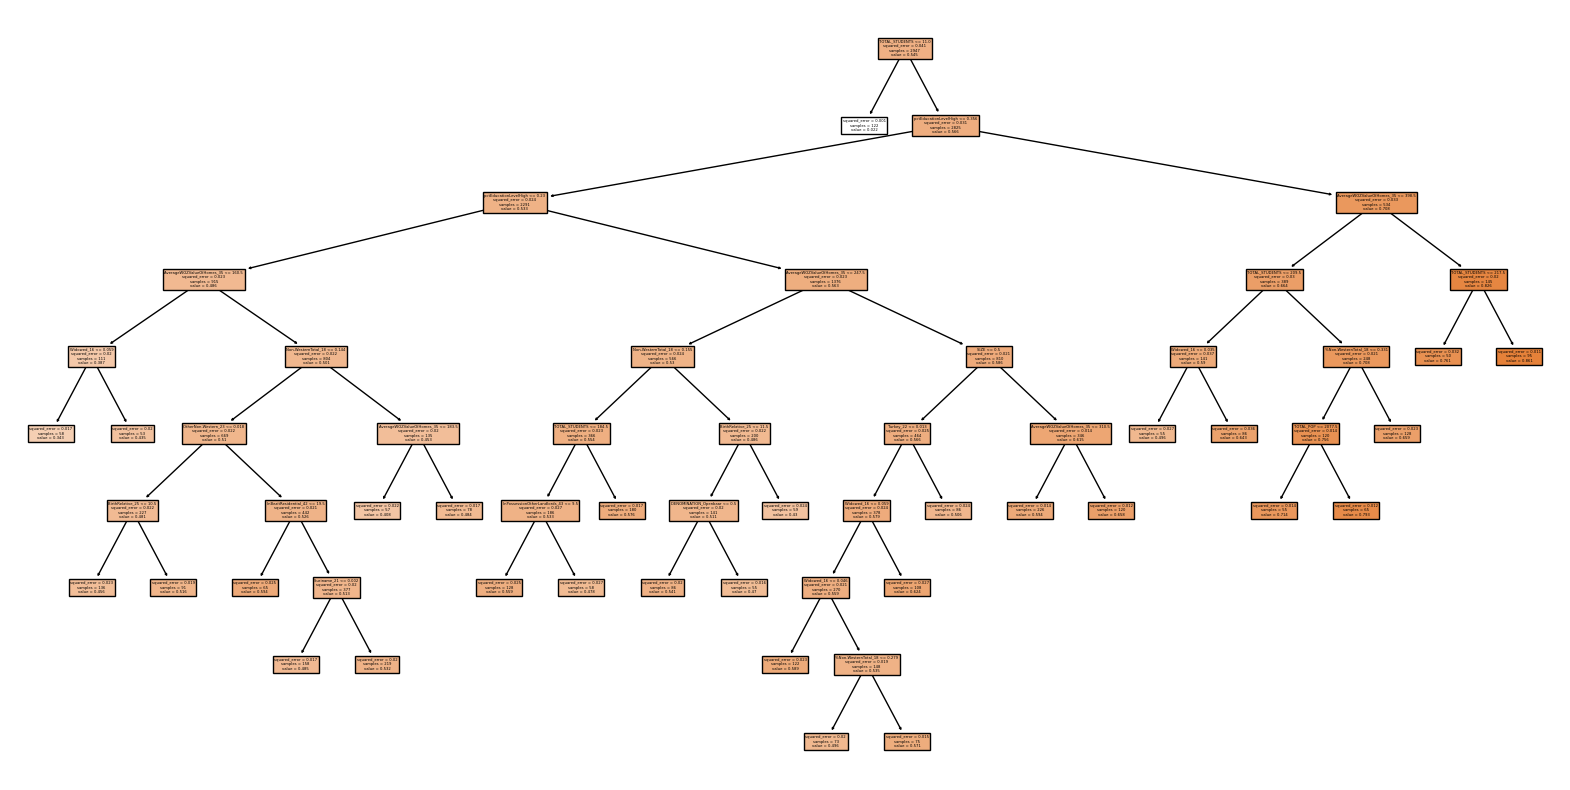

In [29]:
# To obtain an understanding of the complexity of the learned trees, we visualise one of the decision trees populating the forest
fig = plt.figure(figsize=(20,10))

# Tree id to visualise (integer between 0 and n_estimators). You can visualise different trees to assess their diversity
vis_tree = 0

# Create the tree plot
tree.plot_tree(rf.estimators_[vis_tree], feature_names = features, filled=True)

# Show the plot
plt.show()

Let's see which features are found to be most important to our Random Forest.

Top 5 most important features:
 ['TOTAL_STUDENTS', 'pctEducationLevelHigh', 'AverageWOZValueOfHomes_35', 'pctEducationLevelLow', '%Non-WesternTotal_18', 'ADIVCE_GIVEN']


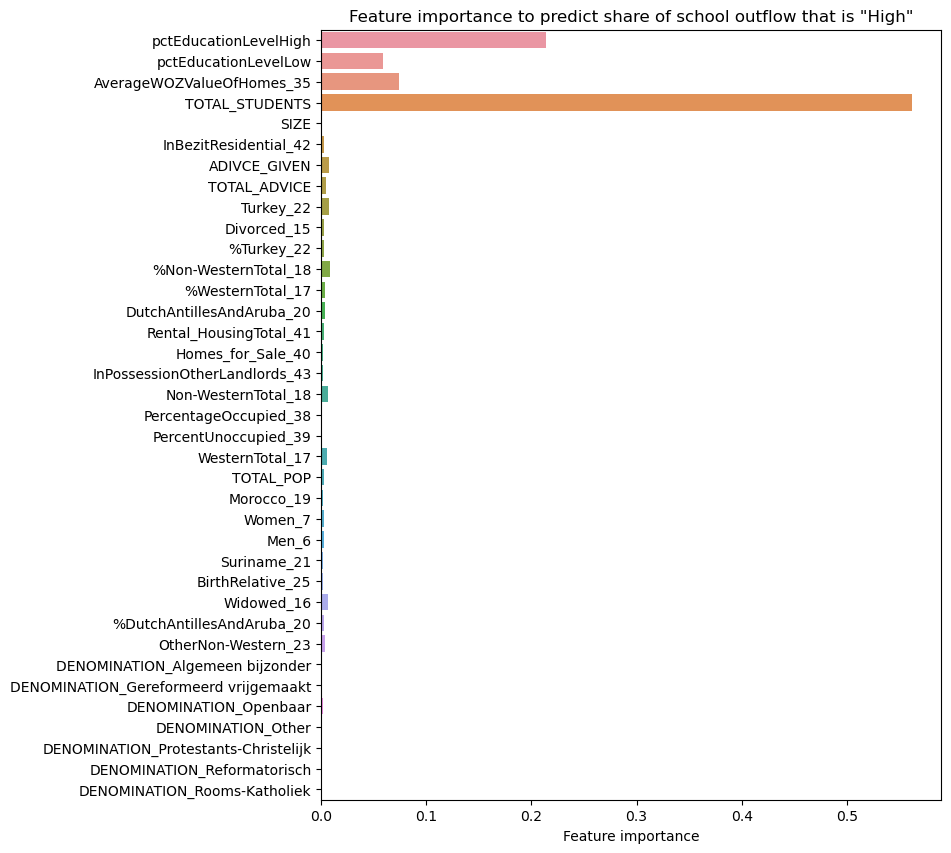

In [30]:
# Plot the feature importances
fig, ax = plt.subplots(figsize=(8,10))
sns.barplot(y=features,x=rf.feature_importances_, ax = ax).set(title='Feature importance to predict share of school outflow that is "High"')
ax.set_xlabel('Feature importance')

# Print most important features
sorted_indices = np.argsort(rf.feature_importances_)[::-1]
most_imp_features_rf = [features[i] for i in sorted_indices]
print(f'Top 5 most important features:\n {most_imp_features_rf[:6]}')

# Show plot
plt.show()

#### <span style="color:skyblue">Exercise 4: Compare the results of the Random forest with those of the Decision tree, in terms of fit, trees, and feature importance</span> 
`A` What difference do you see in terms of model performance?<br>
`B` What difference do you see in terms of the tree structure? (hint: visualise different trees from the forest to assess diversity) <br>
`C` What difference do you see in terms of the discovered feature performances? Specifically, also look at TOTAL_STUDENTS and DENOMINATION<br>

In [31]:
# CODE YOUR ANSWERS HERE (Use as many cells as you need)
# ANSWERS



#### **3. Comparing and reflecting on the model performances and their outcomes** 

Often it helps the researcher to pull together the outcomes of multiple models. The idea of doing this is closely related to wisdom of the crowd principle. If multiple different model point towards the same conclusion, then the researcher has compounding evidence. In contrast, if different models point towards different conclusions, then the researcher knows the conclusions are weak(er) and sensitive to the choice of model.<br>
Let's pull together the predictions of the 3 ML models, and show them next to one another.

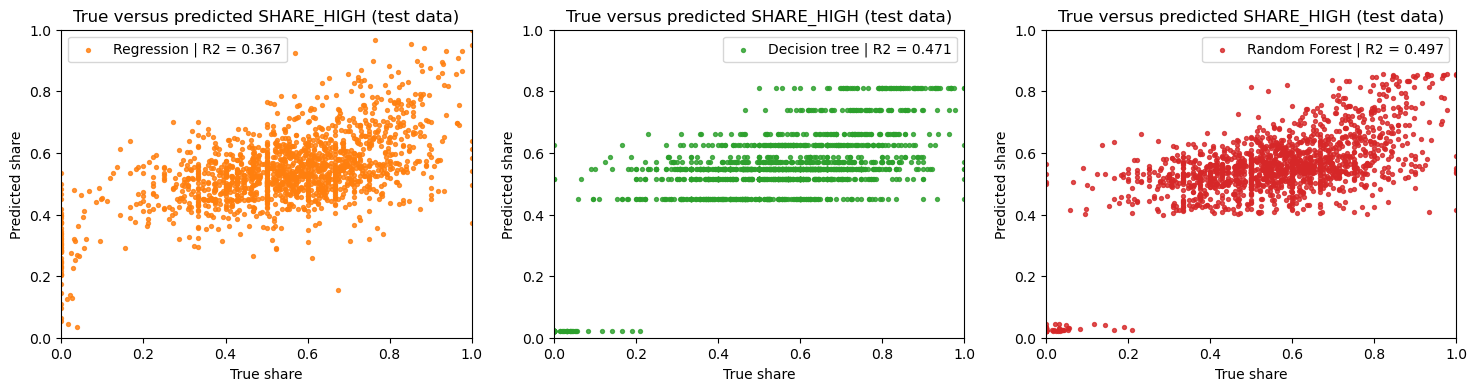

In [32]:
# Scatter true shares (x-axis) against the predicted shares by the different ML models (y-axis)
fig, ax = plt.subplots(1,3,figsize=(18,4))
ax[0].scatter(x = Y_test, y = regr.predict(X_test), s = 8, alpha = 0.8, c = '#ff7f0e', label = f'Regression | R2 = {regr.score(X_test,Y_test):0.3f}')
ax[1].scatter(x = Y_test, y = dt.predict(X_test),   s = 8, alpha = 0.8, c = '#2ca02c', label = f'Decision tree | R2 = {dt.score(X_test,Y_test):0.3f}')
ax[2].scatter(x = Y_test, y = rf.predict(X_test),   s = 8, alpha = 0.8, c = '#d62728', label = f'Random Forest | R2 = {rf.score(X_test,Y_test):0.3f}')

# Add labels, legend, and title to each plot
for n in range(0,3,1):
    ax[n].set_xlabel('True share')
    ax[n].set_ylabel('Predicted share')
    ax[n].set_xlim(0,1)
    ax[n].set_ylim(0,1)
    ax[n].legend()
    ax[n].set_title('True versus predicted SHARE_HIGH (test data)')

plt.show()

### <span style="color:skyblue">Exercise 5:  Comparison of predictions</span> 
`A` What is the most striking difference between the predictions across the three ML models? Can you explain this?<br>
`B` How would the (ideal) scatter plot look like? I.e. when the model would perfectly predict our target?


##### CODE YOUR ANSWERS HERE (Use as many cells as you need)

A Distribution of predicted share, shape at low 'true share' 

B Most ideal scatterplot would be a straight line trough the origin. 

Another way the compare the predictions of the three models is by creating a **kernel density plot**. A kernel density plot visualises the distribution, i.e. the probability density, of a variable, in a smooth way, see e.g. [wikipedia.org/wiki/Kernel_density_estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation). 

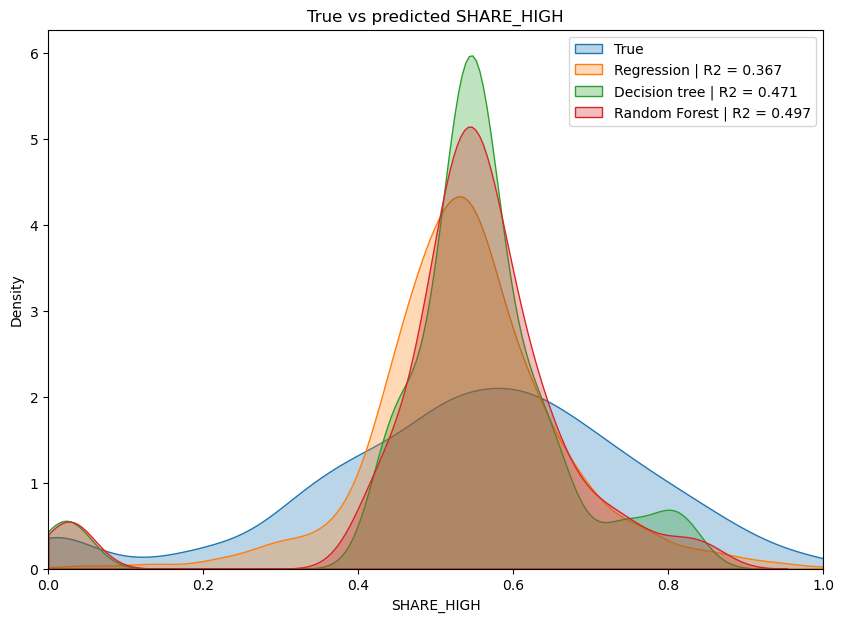

In [34]:
# Plot kernel densities for the test data
fig, ax = plt.subplots(figsize=(10, 7))

# Plot kernel density of the true distribution, i.e of Y_test
sns.kdeplot(data = Y_test, ax=ax, legend=True,fill=True,alpha=.3, clip =(0,1), label = 'True')

# Plot kernel densities of the predicted distributions, based on the three models
sns.kdeplot(data = regr.predict(X_test),ax=ax, legend=True,fill=True,alpha=.3, clip =(0,1), label = f'Regression | R2 = {regr.score(X_test,Y_test):0.3f}')
sns.kdeplot(data = dt.predict(X_test),  ax=ax, legend=True,fill=True,alpha=.3, clip =(0,1), label = f'Decision tree | R2 = {dt.score(X_test,Y_test):0.3f}')
sns.kdeplot(data = rf.predict(X_test),  ax=ax, legend=True,fill=True,alpha=.3, clip =(0,1), label = f'Random Forest | R2 = {rf.score(X_test,Y_test):0.3f}')

# Add legend and title to the plot
#ax.legend(['True','Regression model', 'Decision tree','Random Forest'])
ax.legend()
plt.title('True vs predicted SHARE_HIGH')
ax.set_xlim(0,1)
plt.show()

#### **4. Complementarity of the models**
- Each model gives us different insights on the relationship explored.
- The linear regression model gives a quick overview of the associations between the variable we want to predict and the features we have.
- The linear regression mode cannot capture nonlinear relationships without intervention from the analyst: **the size of the school** has a very strong impact on the school performance, but this impact is non-linear, and the regression model underfits. 
- The decision tree can capture nonlinear relationships, and the analyst can easily interprete the model.
- However, the decision tree may overfit (for instance if the maximum tree depth is set to high).
- The random forest captures also nonlinear relationships better than the decision tree, but is somehwhat less straightforward to interprete. It reduces the variance of DTs.
- Hence, the first two models are useful in the exploratory analysis phase, while the random forest (and similarly flexible machine learning approaches) are especially useful to improve the predicting power.

##### 4.1. Model development cycle

If you have carefully inspected the trees produced by the DT and RF, you might have noticed the first split is (often) based on very small schools: TOTAL_STUDENTS < 11. When we go back to our data we see that this strongly correlates with a categorical feature called `SPECIES_PO` (see left-hand side boxplot below). Unaware of its meaning, at the start of the data exploration of this lab session we too quickly (and erroneaously) discarded this feature as irrelevant. `SPECIES_PO` has two categories: Bo and Sbo. 'Bo' stands for conventional education, while 'Sbo' stands for special education. Sbo schools are schools specifically targeted to cater for students that would not do well in the standard school system and are ussually small. A simple boxplot shows a strong effect of the `SPECIES_PO` on the target feature (see right-hand side plot below). This relationship totally makes sense. With this new insight we are able to improve the models, e.g. include `SPECIES_PO` specification of the linear regression model in a next cycle of the model development. 

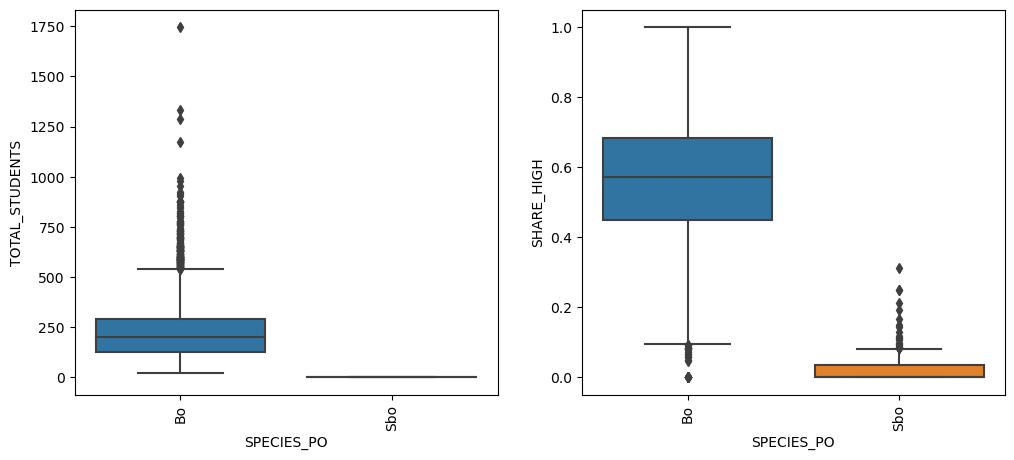

In [35]:
 # Boxplot SPECIES_PO vs SHARE_HIGH
fig, ax = plt.subplots(1,2,figsize =(12,5))
sns.boxplot(x='SPECIES_PO', y='TOTAL_STUDENTS', data=df_schools, ax= ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=90)

sns.boxplot(x='SPECIES_PO', y='SHARE_HIGH', data=df_schools, ax= ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90)
plt.show()

#### <span style="color:skyblue">Exercise 6:   Conclusion and reflection on the results (Discuss with the TAs)</span> 
In this lab session we have analysed the school data, and made predictions for SHARE_HIGH using three ML models.<br>
`A` Based on the above analyses, which of these models can best be used to predict SHARE_HIGH? Explain your answer.<br>
`B` In the kernel density plots, we see that the true variance of SHARE_HIGH (in blue) is considerably larger than the variance of SHARE_HIGH predicted by any of the ML models. What does this tell us about this regression problem?<br>
`C` Answer RQ1: Is the share of school leavers with an advice for higher education, larger at **large schools** than at **small schools**? Or is it impossible to say?<br>
`D` Answer RQ2: Does the type of school (i.e its **denomination**) matters for the share of school leavers with an advice for higher education?  Or is it impossible to say?<br>
`E` How has applying multiple ML models helped you to answer the research questions?<br>

A\
B There is underfitting?\
C Share depends on the size of the school.\
D Type of school matters very little.\
E See whether elements always influence or only sometimes. 

##### **5. Ensemble models**
- Ensemble models are combinations of multiple models.
- In the cell below, we show how to implement an ensemble model.
- That ensemble model is composed of the regression model and decision tree.

In [37]:
# Create ensemble objects
er = VotingRegressor([('lr', regr), ('dt', dt)])

# Fit ensemble objects
er.fit(X_train,Y_train)

# Evaluate the performance of the ensemble
print('Results ensemble')
eval_regression_perf(er,X_train, X_test,Y_train,Y_test)


Results ensemble
Performance
Mean Squared  Error Train | Test: 	 0.0222	|   0.0225
Mean Absolute Error Train | Test: 	 0.1184	|   0.1192
R2                  Train | Test: 	 0.4598	|   0.4716



**Observation:**<br>
* Since the regression model does not perform very well (i.e. without using the SPECIES_PO feature), the ensemble performs worse in this case than the individual DT.